## Reserve and configure resources on KVM

Before you run this experiment, you will:

-   define the specific configuration of resources you need.
-   “instantiate” an experiment with your reserved resources.
-   wait for your resources to be configured.
-   log in to resources to carry out the experiment.

This exercise will guide you through those steps.

### Configure environment

In [1]:
import openstack, chi, chi.ssh, chi.network, chi.server, os

In this section, we configure the Chameleon Python client.

For this experiment, we’re going to use the KVM@TACC site, which we indicate below.

We also need to specify the name of the Chameleon “project” that this experiment is part of. The project name will have the format “CHI-XXXXXX”, where the last part is a 6-digit number, and you can find it on your [user dashboard](https://chameleoncloud.org/user/dashboard/).

In the cell below, replace the project ID with your own project ID, then run the cell.

In [2]:
chi.use_site("KVM@TACC")
PROJECT_NAME = "CHI-231095"
chi.set("project_name", PROJECT_NAME)

# configure openstacksdk for actions unsupported by python-chi
os_conn = chi.clients.connection()


Now using KVM@TACC:
URL: https://kvm.tacc.chameleoncloud.org
Location: Austin, Texas, USA
Support contact: help@chameleoncloud.org


### Define configuration for this experiment (3 VMs)

For this specific experiment, we will need three virtual machines connected to a common network. Each of the virtual machines will be of the `m1.large` type, with 4 VCPUs, 8 GB memory, 40 GB disk space.

In [3]:
username = os.getenv('USER')

node_conf = [
 {'name': "node-0",  'flavor': 'm1.large', 'image': 'CC-Ubuntu20.04', 'packages': ["virtualenv"], 'bastion': True}, 
 {'name': "node-1",  'flavor': 'm1.large', 'image': 'CC-Ubuntu20.04', 'packages': [], 'bastion': False}, 
 {'name': "node-2",  'flavor': 'm1.large', 'image': 'CC-Ubuntu20.04', 'packages': [], 'bastion': False} 
]
net_conf = [
 {"name": "net0", "subnet": "192.168.1.0/24", "nodes": [{"name": "node-0",   "addr": "192.168.1.10"}, {"name": "node-1", "addr": "192.168.1.11"}, {"name": "node-2", "addr": "192.168.1.12"}]},
]
route_conf = []

### Configure resources

Now, we will prepare the VMs and network links that our experiment requires.

First, we will prepare a “public” network that we will use for SSH access to our VMs -

In [4]:
public_net = os_conn.network.create_network(name="public_net_" + username)
public_net_id = public_net.get("id")
public_subnet = os_conn.network.create_subnet(
    name="public_subnet_" + username,
    network_id=public_net.get("id"),
    ip_version='4',
    cidr="192.168.10.0/24",
    gateway_ip="192.168.10.1",
    is_dhcp_enabled = True
)

Next, we will prepare the “experiment” networks -

In [5]:
nets = []
net_ids = []
subnets = []
for n in net_conf:
    exp_net = os_conn.network.create_network(name="exp_" + n['name']  + '_' + username)
    exp_net_id = exp_net.get("id")
    os_conn.network.update_network(exp_net, is_port_security_enabled=False)
    exp_subnet = os_conn.network.create_subnet(
        name="exp_subnet_" + n['name']  + '_' + username,
        network_id=exp_net.get("id"),
        ip_version='4',
        cidr=n['subnet'],
        gateway_ip=None,
        is_dhcp_enabled = True
    )
    nets.append(exp_net)
    net_ids.append(exp_net_id)
    subnets.append(exp_subnet)

Now we create the VMs -

In [8]:
servers = []
server_ids = []
for i, n in enumerate(node_conf, start=10):
    image_uuid = os_conn.image.find_image(n['image']).id
    flavor_uuid = os_conn.compute.find_flavor(n['flavor']).id
    # find out details of exp interface(s)
    nics = [{'net-id': chi.network.get_network_id( "exp_" + net['name']  + '_' + username ), 'v4-fixed-ip': node['addr']} for net in net_conf for node in net['nodes'] if node['name']==n['name']]
    # also include a public network interface
    nics.insert(0, {"net-id": public_net_id, "v4-fixed-ip":"192.168.10." + str(i)})
    server = chi.server.create_server(
        server_name=n['name'] + "_" + username,
        image_id=image_uuid,
        flavor_id=flavor_uuid,
        nics=nics
    )
    servers.append(server)
    server_ids.append(chi.server.get_server(n['name'] + "_" + username).id)

ResourceError: Found multiple networks with name exp_net0_tcz212_nyu_edu

We wait for all servers to come up before we proceed -

In [9]:
for server_id in server_ids:
    chi.server.wait_for_active(server_id)

Next, we will set up SSH access to the VMs.

First, we will make sure the “public” network is connected to the Internet. Then, we will configure it to permit SSH access on port 22 for each port connected to this network.

In [10]:
# connect them to the Internet on the "public" network (e.g. for software installation)
router = chi.network.create_router('inet_router_' + username, gw_network_name='public')
chi.network.add_subnet_to_router(router.get("id"), public_subnet.get("id"))

{'network_id': 'ade69381-b680-45ee-8c1b-5d7e8f37b271',
 'tenant_id': '287158fd03da48e48eb0d2682f38fcc9',
 'subnet_id': '3cd50311-c6ad-404b-ba6a-9d0e7f9d4f26',
 'subnet_ids': ['3cd50311-c6ad-404b-ba6a-9d0e7f9d4f26'],
 'port_id': '573f4543-02b3-48df-997c-dc49ea3817fb',
 'id': 'eb609605-292a-49aa-b97e-0d894881d37e'}

In [12]:
# prepare SSH access on the servers that serve in "bastion" role
# WARNING: this relies on undocumented behavior of associate_floating_ip 
# that it associates the IP with the first port on the server
server_ips = []
for i, n in enumerate(node_conf):
    if 'bastion' in n and n['bastion']:
        ip = chi.server.associate_floating_ip(server_ids[i])
        server_ips.append(ip)

IndexError: list index out of range

In [13]:
if not os_conn.get_security_group("Allow SSH"):
    os_conn.create_security_group("Allow SSH", "Enable SSH traffic on TCP port 22")
    os_conn.create_security_group_rule("Allow SSH", port_range_min=22, port_range_max=22, protocol='tcp', remote_ip_prefix='0.0.0.0/0')

security_group_id = os_conn.get_security_group("Allow SSH").id
for port in chi.network.list_ports(): 
    if port['port_security_enabled'] and port['network_id']==public_net.get("id"):
        os_conn.network.update_port(port['id'], security_groups=[security_group_id])

In [14]:
for ip in server_ips:
    chi.server.wait_for_tcp(ip, port=22)

The following cell may raise an error if some of your nodes are still getting set up! If that happens, wait a few minutes and try again. (And then a few minutes more, and try again, if it still raises an error.)

In [16]:
primary_remote = chi.ssh.Remote(server_ips[0])
physical_ips = [n['addr'] for n in net_conf[0]['nodes']]
server_remotes = [chi.ssh.Remote(physical_ip, gateway=primary_remote) for physical_ip in physical_ips]

IndexError: list index out of range

Finally, we need to configure our resources, including software package installation and network configuration.

In [18]:
import time
for i, n in enumerate(node_conf):
    remote = server_remotes[i]
    # enable forwarding
    remote.run(f"sudo sysctl -w net.ipv4.ip_forward=1") 
    remote.run(f"sudo firewall-cmd --zone=trusted --add-source=192.168.0.0/16 --permanent")
    remote.run(f"sudo firewall-cmd --zone=trusted --add-source=172.16.0.0/12 --permanent")
    remote.run(f"sudo firewall-cmd --zone=trusted --add-source=10.0.0.0/8 --permanent")
    remote.run(f"sudo firewall-cmd --zone=trusted --add-source=127.0.0.0/8 --permanent")
    # these are required for etcd
    remote.run(f"sudo firewall-cmd --zone=public --add-port=4001/tcp")
    remote.run(f"sudo firewall-cmd --zone=public --add-port=2379-2380/tcp")
    time.sleep(3)

NameError: name 'server_remotes' is not defined

In [19]:
for i, n in enumerate(node_conf):
    # install packages
    if len(n['packages']):
            remote = server_remotes[i]
            remote.run(f"sudo apt update; sudo apt -y install " + " ".join(n['packages'])) 

NameError: name 'server_remotes' is not defined

In [20]:
# prepare a "hosts" file that has names and addresses of every node
hosts_txt = [ "%s\t%s" % ( n['addr'], n['name'] ) for net in net_conf  for n in net['nodes'] if type(n) is dict and n['addr']]
for remote in server_remotes:
    for h in hosts_txt:
        remote.run("echo %s | sudo tee -a /etc/hosts > /dev/null" % h)

NameError: name 'server_remotes' is not defined

In [36]:
# we also need to enable incoming traffic on the HTTP port
if not os_conn.get_security_group("Allow HTTP 32000"):
    os_conn.create_security_group("Allow HTTP 32000", "Enable HTTP traffic on TCP port 32000")
    os_conn.create_security_group_rule("Allow HTTP 32000", port_range_min=32000, port_range_max=32000, protocol='tcp', remote_ip_prefix='0.0.0.0/0')

# add existing security group
security_group_id = os_conn.get_security_group("Allow HTTP 32000").id
for port in chi.network.list_ports(): 
    if port['port_security_enabled'] and port['network_id']==public_net.get("id"):
        pri_security_groups = port['security_groups']
        pri_security_groups.append(security_group_id)
        os_conn.network.update_port(port['id'], security_groups=pri_security_groups)

### Draw the network topology

The following cells will draw the network topology, for your reference.

In [37]:
!pip install networkx

In [38]:
nodes = [ (n['name'], {'color': 'pink'}) for n in net_conf ] + [(n['name'], {'color': 'lightblue'}) for n in node_conf ]
edges = [(net['name'], node['name'], 
          {'label': node['addr'] + '/' + net['subnet'].split("/")[1] }) if node['addr'] else (net['name'], node['name']) for net in net_conf for node in net['nodes'] ]

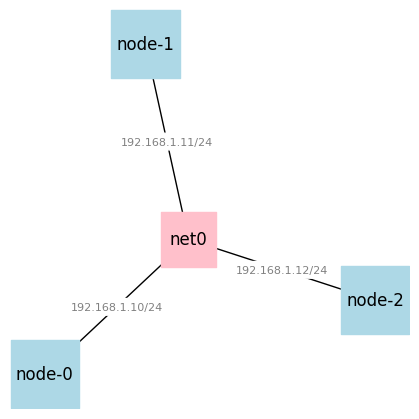

In [39]:
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(len(nodes),len(nodes)))
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw(G, pos, node_shape='s',  
        node_color=[n[1]['color'] for n in nodes], 
        node_size=[len(n[0])*400 for n in nodes],  
        with_labels=True);
nx.draw_networkx_edge_labels(G,pos,
                             edge_labels=nx.get_edge_attributes(G,'label'),
                             font_color='gray',  font_size=8, rotate=False);

### Use Kubespray to prepare a Kubernetes cluster

Now that are resources are “up”, we will use Kubespray, a software utility for preparing and configuring a Kubernetes cluster, to set them up as a cluster.

In [40]:
remote = chi.ssh.Remote(server_ips[0])

In [41]:
# install Python libraries required for Kubespray
remote.run("virtualenv -p python3 myenv")
remote.run("git clone --branch release-2.22 https://github.com/kubernetes-sigs/kubespray.git")
remote.run("source myenv/bin/activate; cd kubespray; pip3 install -r requirements.txt")

/opt/conda/lib/python3.10/site-packages/paramiko/client.py:889: UserWarning: Unknown ssh-ed25519 host key for 129.114.26.102: b'e78449227cefe711cb93a2459b8224e0'
  warnings.warn(


created virtual environment CPython3.8.10.final.0-64 in 500ms
  creator CPython3Posix(dest=/home/cc/myenv, clear=False, global=False)
  seeder FromAppData(download=False, pip=latest, setuptools=latest, wheel=latest, pkg_resources=latest, via=copy, app_data_dir=/home/cc/.local/share/virtualenv/seed-app-data/v1.0.1.debian.1)
  activators BashActivator,CShellActivator,FishActivator,PowerShellActivator,PythonActivator,XonshActivator


Cloning into 'kubespray'...


  Created wheel for ansible: filename=ansible-5.7.1-py3-none-any.whl size=61777681 sha256=88b324cde255e313ddf9f2428f532c7e35998dc405277a9b3d286a85d089a61f
  Stored in directory: /home/cc/.cache/pip/wheels/02/07/2a/7b3eb5d79e268b769b0910cded0d524b4647ae5bc19f3ebb70
  Created wheel for ansible-core: filename=ansible_core-2.12.5-py3-none-any.whl size=2077336 sha256=c4ea48a8bc3d538ff92cf64f71034c93430598316e825bc23c009983eace20aa
  Stored in directory: /home/cc/.cache/pip/wheels/13/09/5b/799a6bc9ca05da9805eaee2afea07e7f63e2ff03b37799d930
Successfully built ansible ansible-core


<Result cmd='source myenv/bin/activate; cd kubespray; pip3 install -r requirements.txt' exited=0>

In [42]:
# copy config files to correct locations
remote.run("mv kubespray/inventory/sample kubespray/inventory/mycluster")
remote.run("git clone https://github.com/teaching-on-testbeds/k8s.git")
remote.run("cp k8s/config/k8s-cluster.yml kubespray/inventory/mycluster/group_vars/k8s_cluster/k8s-cluster.yml")
remote.run("cp k8s/config/inventory.py    kubespray/contrib/inventory_builder/inventory.py")
remote.run("cp k8s/config/addons.yml      kubespray/inventory/mycluster/group_vars/k8s_cluster/addons.yml")

Cloning into 'k8s'...


<Result cmd='cp k8s/config/addons.yml      kubespray/inventory/mycluster/group_vars/k8s_cluster/addons.yml' exited=0>

In [43]:
# build inventory for this specific topology
physical_ips = [n['addr'] for n in net_conf[0]['nodes']]
physical_ips_str = " ".join(physical_ips)
remote.run(f"source myenv/bin/activate; declare -a IPS=({physical_ips_str});"+"cd kubespray; CONFIG_FILE=inventory/mycluster/hosts.yaml python3 contrib/inventory_builder/inventory.py ${IPS[@]}")


DEBUG: Adding group all
DEBUG: Adding group kube_control_plane
DEBUG: Adding group kube_node
DEBUG: Adding group etcd
DEBUG: Adding group k8s_cluster
DEBUG: Adding group calico_rr
DEBUG: adding host node-0 to group all
DEBUG: adding host node-1 to group all
DEBUG: adding host node-2 to group all
DEBUG: adding host node-0 to group etcd
DEBUG: adding host node-1 to group etcd
DEBUG: adding host node-2 to group etcd
DEBUG: adding host node-0 to group kube_control_plane
DEBUG: adding host node-1 to group kube_control_plane
DEBUG: adding host node-0 to group kube_node
DEBUG: adding host node-1 to group kube_node
DEBUG: adding host node-2 to group kube_node


<Result cmd='source myenv/bin/activate; declare -a IPS=(192.168.1.10 192.168.1.11 192.168.1.12);cd kubespray; CONFIG_FILE=inventory/mycluster/hosts.yaml python3 contrib/inventory_builder/inventory.py ${IPS[@]}' exited=0>

In [44]:
# make sure "controller" node can SSH into the others
remote.run('ssh-keygen -t rsa -b 4096 -f ~/.ssh/id_rsa -q -N ""')
public_key = remote.run('cat ~/.ssh/id_rsa.pub').tail("stdout")[2:]

for physical_ip in physical_ips:
    remote_worker = chi.ssh.Remote(physical_ip, gateway=remote)
    remote_worker.run(f'echo {public_key} >> ~/.ssh/authorized_keys') 

ssh-rsa AAAAB3NzaC1yc2EAAAADAQABAAACAQDV9JqsWKMC/N1zF7/KT6YevKjPwyRZgtfy5goWbJdnp3a4u/MN0+bBRwgnk0qaBcfQtm2nXgLE+0cdpPBaNtxT674pGSeZuLTkIglqGSPSSoQdPJa/5TuUxLZldYIjScSC1mqZy4vmQsa/LRNDpZP7PGcf/z/Scj1M4TRecP7/wUSroZGRvlYiU+h9/airOiAYz9nwAMJNBG2BiyHktRRXZCTtTQ1UsUJBPiXl+3jOYveJfH8XrfT93UCInBt44EYhjZdY9hgrANv+E86dt83CCCcuO8C6Ryl3lFZ+s5vFShMq7ENUwPuPfvY/HWWq6fNQBv06/NHZmiUaqhDXK0yeP5vjsEXjeraDfshJkD/kAj/dTHuU8qsX8h14R7zKscWlYrbBWT5SqbAl9JHDteHOmklmWPDqVkcQo8CsyVXRr6L2uOt3SVPyLGLg0WefOw5XdqNoJEjCR94tBIKA9dXkT3NyeLxrF4eYmGvswOPcQqIvepHtu+tQWhIgEYEL0/sXpfbEQJTTYFedS3okDenyduMCX70/NRTTUOc7UOEX04fsFEmtoI2nDO82Os7MxVPlnlTxU2fmLvzyIIzRAd0CBqUJFZbI83zxRNfSsCp+VTuxNwfc0Wh3GxcmHMfBST0N5lsomd0pzdLw0BTqueKCEys7SV6TIRrl1100D6rh4w== cc@node-0-tcz212-nyu-edu


/opt/conda/lib/python3.10/site-packages/paramiko/client.py:889: UserWarning: Unknown ssh-ed25519 host key for 192.168.1.10: b'e78449227cefe711cb93a2459b8224e0'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/paramiko/client.py:889: UserWarning: Unknown ssh-ed25519 host key for 192.168.1.11: b'fa27e272242aeb4d06fb7f3566909e59'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/paramiko/client.py:889: UserWarning: Unknown ssh-ed25519 host key for 192.168.1.12: b'801a24728114835ea0fdeb9fc4c65bb6'
  warnings.warn(


The following cell will actually build the cluster. It will take a long time, and you may see many warnings in the output - that’s OK. The instructions below explain how to tell whether it was successful or not.

The output will be very long, so it will be truncated by default. When you see

    Output of this cell has been trimmed on the initial display.
    Displaying the first 50 top outputs.
    Click on this message to get the complete output.

at the end, click in order to see the rest of the output.

When the process is finished, you will see a “PLAY RECAP” in the output (near the end):

    PLAY RECAP *********************************************************************
    localhost                  : ok=3    changed=0    unreachable=0    failed=0    skipped=0    rescued=0    ignored=0   
    node-0                     : ok=752  changed=149  unreachable=0    failed=0    skipped=1276 rescued=0    ignored=8   
    node-1                     : ok=652  changed=136  unreachable=0    failed=0    skipped=1124 rescued=0    ignored=3   
    node-2                     : ok=535  changed=112  unreachable=0    failed=0    skipped=797  rescued=0    ignored=2   

Make sure that each node shows `failed=0`. If not, you should re-run the cell to re-try the failed parts.

In [45]:
# build the cluster
remote.run("source myenv/bin/activate; cd kubespray; ansible-playbook -i inventory/mycluster/hosts.yaml  --become --become-user=root cluster.yml")

[WARNING]: Skipping callback plugin 'ara_default', unable to load



PLAY [localhost] ***************************************************************
Wednesday 09 October 2024  11:55:39 +0000 (0:00:00.033)       0:00:00.033 ***** 

TASK [Check 2.11.0 <= Ansible version < 2.13.0] ********************************
ok: [localhost] => {
    "changed": false,
    "msg": "All assertions passed"
}
Wednesday 09 October 2024  11:55:39 +0000 (0:00:00.068)       0:00:00.101 ***** 

TASK [Check that python netaddr is installed] **********************************
ok: [localhost] => {
    "changed": false,
    "msg": "All assertions passed"
}
Wednesday 09 October 2024  11:55:40 +0000 (0:00:00.118)       0:00:00.219 ***** 

TASK [Check that jinja is not too old (install via pip)] ***********************
ok: [localhost] => {
    "changed": false,
    "msg": "All assertions passed"
}


[WARNING]: Could not match supplied host pattern, ignoring: kube-master



PLAY [Add kube-master nodes to kube_control_plane] *****************************
skipping: no hosts matched


[WARNING]: Could not match supplied host pattern, ignoring: kube-node



PLAY [Add kube-node nodes to kube_node] ****************************************
skipping: no hosts matched


[WARNING]: Could not match supplied host pattern, ignoring: k8s-cluster



PLAY [Add k8s-cluster nodes to k8s_cluster] ************************************
skipping: no hosts matched


[WARNING]: Could not match supplied host pattern, ignoring: calico-rr



PLAY [Add calico-rr nodes to calico_rr] ****************************************
skipping: no hosts matched

PLAY [Add no-floating nodes to no_floating] ************************************
skipping: no hosts matched


[WARNING]: Could not match supplied host pattern, ignoring: no-floating
[WARNING]: Could not match supplied host pattern, ignoring: bastion



PLAY [bastion[0]] **************************************************************
skipping: no hosts matched

PLAY [k8s_cluster:etcd:calico_rr] **********************************************
Wednesday 09 October 2024  11:55:40 +0000 (0:00:00.101)       0:00:00.321 ***** 
Wednesday 09 October 2024  11:55:40 +0000 (0:00:00.099)       0:00:00.421 ***** 
Wednesday 09 October 2024  11:55:40 +0000 (0:00:00.065)       0:00:00.486 ***** 
Wednesday 09 October 2024  11:55:40 +0000 (0:00:00.063)       0:00:00.550 ***** 
Wednesday 09 October 2024  11:55:40 +0000 (0:00:00.082)       0:00:00.632 ***** 
Wednesday 09 October 2024  11:55:40 +0000 (0:00:00.097)       0:00:00.729 ***** 
Wednesday 09 October 2024  11:55:40 +0000 (0:00:00.086)       0:00:00.815 ***** 
Wednesday 09 October 2024  11:55:40 +0000 (0:00:00.081)       0:00:00.896 ***** 
Wednesday 09 October 2024  11:55:40 +0000 (0:00:00.043)       0:00:00.940 ***** 
Wednesday 09 October 2024  11:55:40 +0000 (0:00:00.081)       0:00:01.022 ***** 

[WARNING]: raw module does not support the environment keyword
[WARNING]: raw module does not support the environment keyword
[WARNING]: raw module does not support the environment keyword



TASK [bootstrap-os : Fetch /etc/os-release] ************************************
ok: [node-0]
ok: [node-1]
ok: [node-2]
Wednesday 09 October 2024  11:55:41 +0000 (0:00:00.390)       0:00:02.020 ***** 
Wednesday 09 October 2024  11:55:41 +0000 (0:00:00.067)       0:00:02.087 ***** 
Wednesday 09 October 2024  11:55:42 +0000 (0:00:00.048)       0:00:02.136 ***** 
Wednesday 09 October 2024  11:55:42 +0000 (0:00:00.052)       0:00:02.189 ***** 
Wednesday 09 October 2024  11:55:42 +0000 (0:00:00.066)       0:00:02.255 ***** 
Wednesday 09 October 2024  11:55:42 +0000 (0:00:00.059)       0:00:02.314 ***** 
Wednesday 09 October 2024  11:55:42 +0000 (0:00:00.060)       0:00:02.375 ***** 

TASK [bootstrap-os : include_tasks] ********************************************
included: /home/cc/kubespray/roles/bootstrap-os/tasks/bootstrap-debian.yml for node-0, node-1, node-2
Wednesday 09 October 2024  11:55:42 +0000 (0:00:00.089)       0:00:02.464 ***** 


[WARNING]: raw module does not support the environment keyword
[WARNING]: raw module does not support the environment keyword
[WARNING]: raw module does not support the environment keyword



TASK [bootstrap-os : Check if bootstrap is needed] *****************************
ok: [node-0]
ok: [node-1]
ok: [node-2]
Wednesday 09 October 2024  11:55:42 +0000 (0:00:00.128)       0:00:02.592 ***** 


[WARNING]: raw module does not support the environment keyword
[WARNING]: raw module does not support the environment keyword
[WARNING]: raw module does not support the environment keyword



TASK [bootstrap-os : Check http::proxy in apt configuration files] *************
ok: [node-0]
ok: [node-1]
ok: [node-2]
Wednesday 09 October 2024  11:55:42 +0000 (0:00:00.163)       0:00:02.755 ***** 
Wednesday 09 October 2024  11:55:42 +0000 (0:00:00.082)       0:00:02.837 ***** 


[WARNING]: raw module does not support the environment keyword
[WARNING]: raw module does not support the environment keyword
[WARNING]: raw module does not support the environment keyword



TASK [bootstrap-os : Check https::proxy in apt configuration files] ************
ok: [node-0]
ok: [node-1]
ok: [node-2]
Wednesday 09 October 2024  11:55:42 +0000 (0:00:00.143)       0:00:02.981 ***** 
Wednesday 09 October 2024  11:55:42 +0000 (0:00:00.067)       0:00:03.048 ***** 
Wednesday 09 October 2024  11:55:43 +0000 (0:00:00.058)       0:00:03.107 ***** 
Wednesday 09 October 2024  11:55:43 +0000 (0:00:00.049)       0:00:03.157 ***** 

TASK [bootstrap-os : Set the ansible_python_interpreter fact] ******************
ok: [node-0]
ok: [node-1]
ok: [node-2]
Wednesday 09 October 2024  11:55:43 +0000 (0:00:00.088)       0:00:03.246 ***** 

TASK [bootstrap-os : Install dbus for the hostname module] *********************
ok: [node-0]
ok: [node-1]
ok: [node-2]
Wednesday 09 October 2024  11:55:48 +0000 (0:00:05.709)       0:00:08.955 ***** 
Wednesday 09 October 2024  11:55:48 +0000 (0:00:00.069)       0:00:09.024 ***** 
Wednesday 09 October 2024  11:55:48 +0000 (0:00:00.066)       0:00:09.

[WARNING]: flush_handlers task does not support when conditional


Wednesday 09 October 2024  11:57:44 +0000 (0:00:00.010)       0:02:04.600 ***** 
Wednesday 09 October 2024  11:57:44 +0000 (0:00:00.146)       0:02:04.746 ***** 

TASK [container-engine/containerd-common : containerd-common | check if fedora coreos] ***
ok: [node-1]
ok: [node-0]
ok: [node-2]
Wednesday 09 October 2024  11:57:45 +0000 (0:00:00.615)       0:02:05.362 ***** 

TASK [container-engine/containerd-common : containerd-common | set is_ostree] ***
ok: [node-0]
ok: [node-1]
ok: [node-2]
Wednesday 09 October 2024  11:57:45 +0000 (0:00:00.144)       0:02:05.506 ***** 

TASK [container-engine/containerd-common : containerd-common | gather os specific variables] ***
ok: [node-0] => (item=/home/cc/kubespray/roles/container-engine/docker/vars/../vars/ubuntu.yml)
ok: [node-1] => (item=/home/cc/kubespray/roles/container-engine/docker/vars/../vars/ubuntu.yml)
ok: [node-2] => (item=/home/cc/kubespray/roles/container-engine/docker/vars/../vars/ubuntu.yml)
Wednesday 09 October 2024  11:57:45 +

[WARNING]: noop task does not support when conditional



TASK [download : prep_kubeadm_images | Create kubeadm config] ******************
changed: [node-0]
changed: [node-1]
Wednesday 09 October 2024  11:59:36 +0000 (0:00:00.943)       0:03:56.301 ***** 

TASK [download : prep_kubeadm_images | Copy kubeadm binary from download dir to system path] ***
changed: [node-0]
changed: [node-1]
Wednesday 09 October 2024  11:59:37 +0000 (0:00:00.998)       0:03:57.299 ***** 

TASK [download : prep_kubeadm_images | Set kubeadm binary permissions] *********
ok: [node-0]
ok: [node-1]
Wednesday 09 October 2024  11:59:37 +0000 (0:00:00.508)       0:03:57.808 ***** 

TASK [download : prep_kubeadm_images | Generate list of required images] *******
ok: [node-0]
Wednesday 09 October 2024  11:59:38 +0000 (0:00:00.598)       0:03:58.406 ***** 

TASK [download : prep_kubeadm_images | Parse list of images] *******************
ok: [node-0] => (item=registry.k8s.io/kube-apiserver:v1.26.5)
ok: [node-0] => (item=registry.k8s.io/kube-controller-manager:v1.26.5)
ok: [n

[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]



TASK [download : download_container | Download image if required] **************
changed: [node-1]
changed: [node-0]
changed: [node-2]
Wednesday 09 October 2024  12:00:39 +0000 (0:00:10.430)       0:05:00.036 ***** 
Wednesday 09 October 2024  12:00:40 +0000 (0:00:00.077)       0:05:00.114 ***** 
Wednesday 09 October 2024  12:00:40 +0000 (0:00:00.113)       0:05:00.228 ***** 
Wednesday 09 October 2024  12:00:40 +0000 (0:00:00.086)       0:05:00.314 ***** 
Wednesday 09 October 2024  12:00:40 +0000 (0:00:00.085)       0:05:00.399 ***** 

TASK [download : download_container | Remove container image from cache] *******
ok: [node-0]
ok: [node-1]
ok: [node-2]
Wednesday 09 October 2024  12:00:40 +0000 (0:00:00.546)       0:05:00.946 ***** 

TASK [download : set default values for flag variables] ************************
ok: [node-0]
ok: [node-1]
ok: [node-2]
Wednesday 09 October 2024  12:00:40 +0000 (0:00:00.116)       0:05:01.063 ***** 

TASK [download : set_container_facts | Display the nam

[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]



TASK [download : download_container | Download image if required] **************
changed: [node-0]
changed: [node-2]
changed: [node-1]
Wednesday 09 October 2024  12:00:52 +0000 (0:00:08.346)       0:05:12.401 ***** 
Wednesday 09 October 2024  12:00:52 +0000 (0:00:00.084)       0:05:12.486 ***** 
Wednesday 09 October 2024  12:00:52 +0000 (0:00:00.130)       0:05:12.617 ***** 
Wednesday 09 October 2024  12:00:52 +0000 (0:00:00.109)       0:05:12.727 ***** 
Wednesday 09 October 2024  12:00:52 +0000 (0:00:00.109)       0:05:12.837 ***** 

TASK [download : download_container | Remove container image from cache] *******
ok: [node-0]
ok: [node-1]
ok: [node-2]
Wednesday 09 October 2024  12:00:53 +0000 (0:00:00.575)       0:05:13.413 ***** 

TASK [download : set default values for flag variables] ************************
ok: [node-0]
ok: [node-1]
ok: [node-2]
Wednesday 09 October 2024  12:00:53 +0000 (0:00:00.143)       0:05:13.557 ***** 

TASK [download : set_container_facts | Display the nam

[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]



TASK [download : download_container | Download image if required] **************
changed: [node-0]
changed: [node-1]
changed: [node-2]
Wednesday 09 October 2024  12:01:03 +0000 (0:00:07.091)       0:05:23.522 ***** 
Wednesday 09 October 2024  12:01:03 +0000 (0:00:00.073)       0:05:23.596 ***** 
Wednesday 09 October 2024  12:01:03 +0000 (0:00:00.115)       0:05:23.711 ***** 
Wednesday 09 October 2024  12:01:03 +0000 (0:00:00.109)       0:05:23.820 ***** 
Wednesday 09 October 2024  12:01:03 +0000 (0:00:00.101)       0:05:23.922 ***** 

TASK [download : download_container | Remove container image from cache] *******
ok: [node-0]
ok: [node-1]
ok: [node-2]
Wednesday 09 October 2024  12:01:04 +0000 (0:00:00.531)       0:05:24.453 ***** 

TASK [download : set default values for flag variables] ************************
ok: [node-0]
ok: [node-1]
ok: [node-2]
Wednesday 09 October 2024  12:01:04 +0000 (0:00:00.124)       0:05:24.578 ***** 

TASK [download : set_container_facts | Display the nam

[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]



TASK [download : download_container | Download image if required] **************
changed: [node-1]
changed: [node-2]
changed: [node-0]
Wednesday 09 October 2024  12:01:14 +0000 (0:00:07.683)       0:05:35.087 ***** 
Wednesday 09 October 2024  12:01:15 +0000 (0:00:00.077)       0:05:35.165 ***** 
Wednesday 09 October 2024  12:01:15 +0000 (0:00:00.122)       0:05:35.288 ***** 
Wednesday 09 October 2024  12:01:15 +0000 (0:00:00.117)       0:05:35.406 ***** 
Wednesday 09 October 2024  12:01:15 +0000 (0:00:00.108)       0:05:35.514 ***** 

TASK [download : download_container | Remove container image from cache] *******
ok: [node-0]
ok: [node-1]
ok: [node-2]
Wednesday 09 October 2024  12:01:15 +0000 (0:00:00.565)       0:05:36.080 ***** 

TASK [download : prep_download | Set a few facts] ******************************
ok: [node-0]
ok: [node-1]
Wednesday 09 October 2024  12:01:16 +0000 (0:00:00.098)       0:05:36.179 ***** 

TASK [download : download_file | Starting download of file] *******

[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]



TASK [download : download_container | Download image if required] **************
changed: [node-1]
changed: [node-0]
changed: [node-2]
Wednesday 09 October 2024  12:01:28 +0000 (0:00:01.559)       0:05:48.417 ***** 
Wednesday 09 October 2024  12:01:28 +0000 (0:00:00.065)       0:05:48.482 ***** 
Wednesday 09 October 2024  12:01:28 +0000 (0:00:00.121)       0:05:48.603 ***** 
Wednesday 09 October 2024  12:01:28 +0000 (0:00:00.097)       0:05:48.701 ***** 
Wednesday 09 October 2024  12:01:28 +0000 (0:00:00.092)       0:05:48.794 ***** 

TASK [download : download_container | Remove container image from cache] *******
ok: [node-0]
ok: [node-1]
ok: [node-2]
Wednesday 09 October 2024  12:01:29 +0000 (0:00:00.510)       0:05:49.304 ***** 

TASK [download : set default values for flag variables] ************************
ok: [node-0]
ok: [node-1]
ok: [node-2]
Wednesday 09 October 2024  12:01:29 +0000 (0:00:00.123)       0:05:49.428 ***** 

TASK [download : set_container_facts | Display the nam

[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]



TASK [download : download_container | Download image if required] **************
changed: [node-1]
changed: [node-2]
changed: [node-0]
Wednesday 09 October 2024  12:01:35 +0000 (0:00:03.462)       0:05:55.888 ***** 
Wednesday 09 October 2024  12:01:35 +0000 (0:00:00.070)       0:05:55.958 ***** 
Wednesday 09 October 2024  12:01:35 +0000 (0:00:00.101)       0:05:56.059 ***** 
Wednesday 09 October 2024  12:01:36 +0000 (0:00:00.092)       0:05:56.152 ***** 
Wednesday 09 October 2024  12:01:36 +0000 (0:00:00.093)       0:05:56.246 ***** 

TASK [download : download_container | Remove container image from cache] *******
ok: [node-1]
ok: [node-0]
ok: [node-2]
Wednesday 09 October 2024  12:01:36 +0000 (0:00:00.526)       0:05:56.773 ***** 

TASK [download : set default values for flag variables] ************************
ok: [node-0]
ok: [node-1]
ok: [node-2]
Wednesday 09 October 2024  12:01:36 +0000 (0:00:00.114)       0:05:56.887 ***** 

TASK [download : set_container_facts | Display the nam

[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]



TASK [download : download_container | Download image if required] **************
changed: [node-1]
changed: [node-2]
changed: [node-0]
Wednesday 09 October 2024  12:01:42 +0000 (0:00:03.009)       0:06:02.465 ***** 
Wednesday 09 October 2024  12:01:42 +0000 (0:00:00.057)       0:06:02.522 ***** 
Wednesday 09 October 2024  12:01:42 +0000 (0:00:00.109)       0:06:02.631 ***** 
Wednesday 09 October 2024  12:01:42 +0000 (0:00:00.098)       0:06:02.729 ***** 
Wednesday 09 October 2024  12:01:42 +0000 (0:00:00.232)       0:06:02.962 ***** 

TASK [download : download_container | Remove container image from cache] *******
ok: [node-0]
ok: [node-1]
ok: [node-2]
Wednesday 09 October 2024  12:01:43 +0000 (0:00:00.507)       0:06:03.470 ***** 

TASK [download : set default values for flag variables] ************************
ok: [node-0]
ok: [node-1]
ok: [node-2]
Wednesday 09 October 2024  12:01:43 +0000 (0:00:00.131)       0:06:03.601 ***** 

TASK [download : set_container_facts | Display the nam

[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]



TASK [download : download_container | Download image if required] **************
changed: [node-1]
changed: [node-2]
changed: [node-0]
Wednesday 09 October 2024  12:01:52 +0000 (0:00:06.555)       0:06:12.718 ***** 
Wednesday 09 October 2024  12:01:52 +0000 (0:00:00.069)       0:06:12.788 ***** 
Wednesday 09 October 2024  12:01:52 +0000 (0:00:00.110)       0:06:12.899 ***** 
Wednesday 09 October 2024  12:01:52 +0000 (0:00:00.118)       0:06:13.017 ***** 
Wednesday 09 October 2024  12:01:53 +0000 (0:00:00.108)       0:06:13.126 ***** 

TASK [download : download_container | Remove container image from cache] *******
ok: [node-0]
ok: [node-1]
ok: [node-2]
Wednesday 09 October 2024  12:01:53 +0000 (0:00:00.571)       0:06:13.697 ***** 

TASK [download : set default values for flag variables] ************************
ok: [node-0]
ok: [node-1]
Wednesday 09 October 2024  12:01:53 +0000 (0:00:00.103)       0:06:13.801 ***** 

TASK [download : set_container_facts | Display the name of the imag

[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]



TASK [download : download_container | Download image if required] **************
changed: [node-1]
changed: [node-0]
Wednesday 09 October 2024  12:02:00 +0000 (0:00:04.817)       0:06:20.824 ***** 
Wednesday 09 October 2024  12:02:00 +0000 (0:00:00.076)       0:06:20.901 ***** 
Wednesday 09 October 2024  12:02:00 +0000 (0:00:00.084)       0:06:20.986 ***** 
Wednesday 09 October 2024  12:02:00 +0000 (0:00:00.072)       0:06:21.058 ***** 
Wednesday 09 October 2024  12:02:01 +0000 (0:00:00.066)       0:06:21.124 ***** 

TASK [download : download_container | Remove container image from cache] *******
ok: [node-0]
ok: [node-1]
Wednesday 09 October 2024  12:02:01 +0000 (0:00:00.497)       0:06:21.622 ***** 

TASK [download : set default values for flag variables] ************************
ok: [node-0]
ok: [node-1]
Wednesday 09 October 2024  12:02:01 +0000 (0:00:00.101)       0:06:21.724 ***** 

TASK [download : set_container_facts | Display the name of the image being processed] ***
ok: [nod

[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]



TASK [download : download_container | Download image if required] **************
changed: [node-0]
changed: [node-1]
Wednesday 09 October 2024  12:02:09 +0000 (0:00:05.246)       0:06:29.200 ***** 
Wednesday 09 October 2024  12:02:09 +0000 (0:00:00.080)       0:06:29.281 ***** 
Wednesday 09 October 2024  12:02:09 +0000 (0:00:00.081)       0:06:29.362 ***** 
Wednesday 09 October 2024  12:02:09 +0000 (0:00:00.068)       0:06:29.431 ***** 
Wednesday 09 October 2024  12:02:09 +0000 (0:00:00.081)       0:06:29.512 ***** 

TASK [download : download_container | Remove container image from cache] *******
ok: [node-0]
ok: [node-1]
Wednesday 09 October 2024  12:02:09 +0000 (0:00:00.502)       0:06:30.015 ***** 

TASK [download : set default values for flag variables] ************************
ok: [node-0]
ok: [node-1]
Wednesday 09 October 2024  12:02:10 +0000 (0:00:00.095)       0:06:30.110 ***** 

TASK [download : set_container_facts | Display the name of the image being processed] ***
ok: [nod

[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]



TASK [download : download_container | Download image if required] **************
changed: [node-1]
changed: [node-0]
Wednesday 09 October 2024  12:02:19 +0000 (0:00:07.481)       0:06:39.835 ***** 
Wednesday 09 October 2024  12:02:19 +0000 (0:00:00.069)       0:06:39.904 ***** 
Wednesday 09 October 2024  12:02:19 +0000 (0:00:00.078)       0:06:39.983 ***** 
Wednesday 09 October 2024  12:02:19 +0000 (0:00:00.067)       0:06:40.050 ***** 
Wednesday 09 October 2024  12:02:20 +0000 (0:00:00.088)       0:06:40.138 ***** 

TASK [download : download_container | Remove container image from cache] *******
ok: [node-0]
ok: [node-1]
Wednesday 09 October 2024  12:02:20 +0000 (0:00:00.492)       0:06:40.631 ***** 

TASK [download : set default values for flag variables] ************************
ok: [node-0]
ok: [node-1]
ok: [node-2]
Wednesday 09 October 2024  12:02:20 +0000 (0:00:00.135)       0:06:40.766 ***** 

TASK [download : set_container_facts | Display the name of the image being processed]

[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]



TASK [download : download_container | Download image if required] **************
changed: [node-0]
changed: [node-2]
changed: [node-1]
Wednesday 09 October 2024  12:02:30 +0000 (0:00:06.606)       0:06:50.242 ***** 
Wednesday 09 October 2024  12:02:30 +0000 (0:00:00.065)       0:06:50.307 ***** 
Wednesday 09 October 2024  12:02:30 +0000 (0:00:00.129)       0:06:50.437 ***** 
Wednesday 09 October 2024  12:02:30 +0000 (0:00:00.117)       0:06:50.555 ***** 
Wednesday 09 October 2024  12:02:30 +0000 (0:00:00.106)       0:06:50.661 ***** 

TASK [download : download_container | Remove container image from cache] *******
ok: [node-0]
ok: [node-1]
ok: [node-2]
Wednesday 09 October 2024  12:02:31 +0000 (0:00:00.581)       0:06:51.242 ***** 

TASK [download : set default values for flag variables] ************************
ok: [node-0]
ok: [node-1]
ok: [node-2]
Wednesday 09 October 2024  12:02:31 +0000 (0:00:00.151)       0:06:51.394 ***** 

TASK [download : set_container_facts | Display the nam

[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]



TASK [download : download_container | Download image if required] **************
changed: [node-1]
changed: [node-2]
changed: [node-0]
Wednesday 09 October 2024  12:02:41 +0000 (0:00:07.342)       0:07:01.573 ***** 
Wednesday 09 October 2024  12:02:41 +0000 (0:00:00.074)       0:07:01.647 ***** 
Wednesday 09 October 2024  12:02:41 +0000 (0:00:00.115)       0:07:01.763 ***** 
Wednesday 09 October 2024  12:02:41 +0000 (0:00:00.095)       0:07:01.859 ***** 
Wednesday 09 October 2024  12:02:41 +0000 (0:00:00.090)       0:07:01.949 ***** 

TASK [download : download_container | Remove container image from cache] *******
ok: [node-0]
ok: [node-1]
ok: [node-2]
Wednesday 09 October 2024  12:02:42 +0000 (0:00:00.514)       0:07:02.464 ***** 

TASK [download : set default values for flag variables] ************************
ok: [node-0]
ok: [node-1]
ok: [node-2]
Wednesday 09 October 2024  12:02:42 +0000 (0:00:00.133)       0:07:02.597 ***** 

TASK [download : set_container_facts | Display the nam

[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]



TASK [download : download_container | Download image if required] **************
changed: [node-0]
changed: [node-2]
changed: [node-1]
Wednesday 09 October 2024  12:02:50 +0000 (0:00:04.843)       0:07:10.260 ***** 
Wednesday 09 October 2024  12:02:50 +0000 (0:00:00.071)       0:07:10.332 ***** 
Wednesday 09 October 2024  12:02:50 +0000 (0:00:00.120)       0:07:10.453 ***** 
Wednesday 09 October 2024  12:02:50 +0000 (0:00:00.105)       0:07:10.559 ***** 
Wednesday 09 October 2024  12:02:50 +0000 (0:00:00.088)       0:07:10.647 ***** 

TASK [download : download_container | Remove container image from cache] *******
ok: [node-0]
ok: [node-1]
ok: [node-2]
Wednesday 09 October 2024  12:02:51 +0000 (0:00:00.540)       0:07:11.187 ***** 

TASK [download : set default values for flag variables] ************************
ok: [node-0]
ok: [node-1]
ok: [node-2]
Wednesday 09 October 2024  12:02:51 +0000 (0:00:00.142)       0:07:11.330 ***** 

TASK [download : set_container_facts | Display the nam

[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]
[WARNING]: could not parse environment value, skipping: ['{{ proxy_disable_env
}}', "{{ proxy_env if container_manager == 'containerd' else omit }}"]



TASK [download : download_container | Download image if required] **************
changed: [node-2]
changed: [node-0]
changed: [node-1]
Wednesday 09 October 2024  12:02:59 +0000 (0:00:05.167)       0:07:19.342 ***** 
Wednesday 09 October 2024  12:02:59 +0000 (0:00:00.076)       0:07:19.418 ***** 
Wednesday 09 October 2024  12:02:59 +0000 (0:00:00.116)       0:07:19.535 ***** 
Wednesday 09 October 2024  12:02:59 +0000 (0:00:00.096)       0:07:19.631 ***** 
Wednesday 09 October 2024  12:02:59 +0000 (0:00:00.090)       0:07:19.722 ***** 

TASK [download : download_container | Remove container image from cache] *******
ok: [node-0]
ok: [node-1]
ok: [node-2]

PLAY [etcd:kube_control_plane] *************************************************
Wednesday 09 October 2024  12:03:00 +0000 (0:00:00.616)       0:07:20.338 ***** 
Wednesday 09 October 2024  12:03:00 +0000 (0:00:00.108)       0:07:20.447 ***** 
Wednesday 09 October 2024  12:03:00 +0000 (0:00:00.059)       0:07:20.507 ***** 
Wednesday 09 

[WARNING]: Skipped '/etc/ssl/etcd/ssl' path due to this access issue:
'/etc/ssl/etcd/ssl' is not a directory



TASK [etcd : Check_certs | Register certs that have already been generated on first etcd node] ***
ok: [node-0]
Wednesday 09 October 2024  12:03:05 +0000 (0:00:00.309)       0:07:25.825 ***** 

TASK [etcd : Check_certs | Set default value for 'sync_certs', 'gen_certs' and 'etcd_secret_changed' to false] ***
ok: [node-0]
ok: [node-1]
ok: [node-2]
Wednesday 09 October 2024  12:03:05 +0000 (0:00:00.094)       0:07:25.920 ***** 

TASK [etcd : Check certs | Register ca and etcd admin/member certs on etcd hosts] ***
ok: [node-0] => (item=ca.pem)
ok: [node-1] => (item=ca.pem)
ok: [node-2] => (item=ca.pem)
ok: [node-0] => (item=member-node-0.pem)
ok: [node-1] => (item=member-node-1.pem)
ok: [node-2] => (item=member-node-2.pem)
ok: [node-0] => (item=member-node-0-key.pem)
ok: [node-1] => (item=member-node-1-key.pem)
ok: [node-2] => (item=member-node-2-key.pem)
ok: [node-0] => (item=admin-node-0.pem)
ok: [node-1] => (item=admin-node-1.pem)
ok: [node-2] => (item=admin-node-2.pem)
ok: [node-0] =>

<Result cmd='source myenv/bin/activate; cd kubespray; ansible-playbook -i inventory/mycluster/hosts.yaml  --become --become-user=root cluster.yml' exited=0>

In [46]:
# allow kubectl access for non-root user
remote.run("sudo cp -R /root/.kube /home/cc/.kube; sudo chown -R cc /home/cc/.kube; sudo chgrp -R cc /home/cc/.kube")

<Result cmd='sudo cp -R /root/.kube /home/cc/.kube; sudo chown -R cc /home/cc/.kube; sudo chgrp -R cc /home/cc/.kube' exited=0>

In [47]:
# check installation
remote.run("kubectl get nodes")

NAME     STATUS   ROLES           AGE     VERSION
node-0   Ready    control-plane   4m52s   v1.26.5
node-1   Ready    control-plane   4m18s   v1.26.5
node-2   Ready    <none>          3m19s   v1.26.5


<Result cmd='kubectl get nodes' exited=0>

### Set up Docker

Now that we have a Kubernetes cluster, we have a framework in place for container orchestration. But we still need to set up Docker, for building, sharing, and running those containers.

In [53]:
# add the user to the "docker" group on all hosts
for physical_ip in physical_ips:
    remote_worker = chi.ssh.Remote(physical_ip, gateway=remote)
    remote_worker.run("sudo groupadd -f docker; sudo usermod -aG docker $USER")

In [54]:
# set up a private distribution registry on the "controller" node for distributing containers
# note: need a brand-new SSH session in order to "get" new group membership
remote = chi.ssh.Remote(server_ips[0])
remote.run("docker run -d -p 5000:5000 --restart always --name registry registry:2")

docker: Error response from daemon: Conflict. The container name "/registry" is already in use by container "18094f3cac0ddaae0dd1af4dc2a5a724a9344a78fad9d82c8cce29fc4d6b8e32". You have to remove (or rename) that container to be able to reuse that name.
See 'docker run --help'.


UnexpectedExit: Encountered a bad command exit code!

Command: 'docker run -d -p 5000:5000 --restart always --name registry registry:2'

Exit code: 125

Stdout: already printed

Stderr: already printed



In [55]:
# set up docker configuration on all the hosts
for physical_ip in physical_ips:
    remote_worker = chi.ssh.Remote(physical_ip, gateway=remote)
    remote_worker.run("sudo wget https://raw.githubusercontent.com/teaching-on-testbeds/k8s/main/config/daemon.json -O /etc/docker/daemon.json")
    remote_worker.run("sudo service docker restart")


--2024-10-09 12:13:39--  https://raw.githubusercontent.com/teaching-on-testbeds/k8s/main/config/daemon.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65 [text/plain]
Saving to: ‘/etc/docker/daemon.json’

     0K                                                       100% 2.43M=0s

2024-10-09 12:13:39 (2.43 MB/s) - ‘/etc/docker/daemon.json’ saved [65/65]

--2024-10-09 12:13:50--  https://raw.githubusercontent.com/teaching-on-testbeds/k8s/main/config/daemon.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65 [text/plain]
Sa

In [56]:
# check configuration
remote.run("docker run hello-world")


Hello from Docker!
This message shows that your installation appears to be working correctly.

To generate this message, Docker took the following steps:
 1. The Docker client contacted the Docker daemon.
 2. The Docker daemon pulled the "hello-world" image from the Docker Hub.
    (amd64)
 3. The Docker daemon created a new container from that image which runs the
    executable that produces the output you are currently reading.
 4. The Docker daemon streamed that output to the Docker client, which sent it
    to your terminal.

To try something more ambitious, you can run an Ubuntu container with:
 $ docker run -it ubuntu bash

Share images, automate workflows, and more with a free Docker ID:
 https://hub.docker.com/

For more examples and ideas, visit:
 https://docs.docker.com/get-started/



<Result cmd='docker run hello-world' exited=0>

### Get SSH login details

At this point, we should be able to log in to our “controller” node over SSH! Run the following cell, and observe the output - you will see an SSH command this node.

In [57]:
print("ssh cc@" + server_ips[0])

ssh cc@129.114.26.102


Now, you can open an SSH session as follows:

-   In Jupyter, from the menu bar, use File \> New \> Terminal to open a new terminal.
-   Copy the SSH command from the output above, and paste it into the terminal.

Alternatively, you can use your local terminal to log on to each node, if you prefer. (On your local terminal, you may need to also specify your key path as part of the SSH command, using the `-i` argument followed by the path to your private key.)